# Домашнее задание 9. Настройка композиций алгоритмов

В этом задании вы настроите случайный лес, градиентный бустинг, а также их композицию на данных
соревнования [Mercedes-Benz Greener Manufacturing](https://www.kaggle.com/c/mercedes-benz-greener-manufacturing).

Данные загружаются сразу из гитхаба ниже.

Кратко о задаче: объекты - автомобили, целевая переменная - время, за которое автомобиль проходит тест, задача регрессии, качество измеряется с помощью $R^2$-метрики.

Скрипт загрузки и базовой предобработки данных взят с [Kaggle Kernels](https://www.kaggle.com/anokas/mercedes-eda-xgboost-starter-0-55/notebook). В этом же ядре приводится базовый exploration данных, можете почитать после семинара.

## Загрузка данных

In [2]:
import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [23]:
df_train = pd.read_csv('https://raw.githubusercontent.com/nadiinchi/hse_cs_ml_course_2017_FTAD/master/materials/train.csv')
print('Size of training set: {} rows and {} columns'.format(*df_train.shape))
df_train.head()

Size of training set: 4209 rows and 378 columns


,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


Распределение целевого признака:

min: 72.11 max: 265.32 mean: 100.66931812782134 std: 12.6778749695168
Count of values above 180: 1


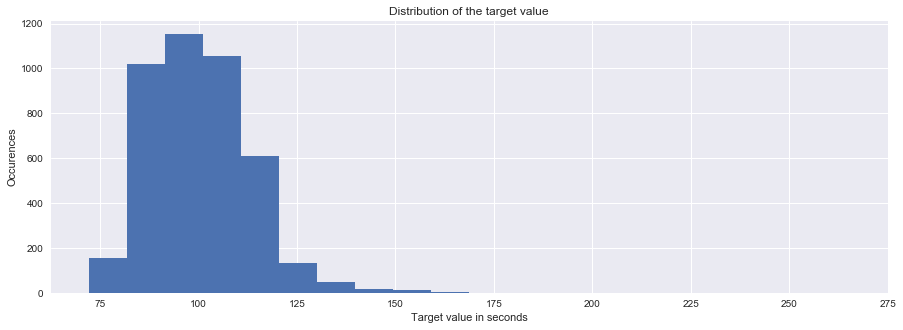

In [4]:
y_train = df_train['y'].values
plt.figure(figsize=(15, 5))
plt.hist(y_train, bins=20)
plt.xlabel('Target value in seconds')
plt.ylabel('Occurences')
plt.title('Distribution of the target value')

print('min: {} max: {} mean: {} std: {}'.format(min(y_train), max(y_train), y_train.mean(), y_train.std()))
print('Count of values above 180: {}'.format(np.sum(y_train > 200)))

Число признаков и объектов:

In [5]:
cols = [c for c in df_train.columns if 'X' in c]
print('Number of features: {}'.format(len(cols)))

print('Feature types:')
df_train[cols].dtypes.value_counts()

Number of features: 376
Feature types:


int64     368
object      8
dtype: int64

Приведение данных к вещественному виду:

In [6]:
usable_columns = list(set(df_train.columns) - set(['ID', 'y']))
y_train = df_train['y'].values
x_train = df_train[usable_columns]
for column in usable_columns:
    cardinality = len(np.unique(x_train[column]))
    if cardinality == 1:
        x_train.drop(column, axis=1) # Column with only one value is useless so we drop it
    if cardinality > 2: # Column is categorical
        mapper = lambda x: sum([ord(digit) for digit in x])
        x_train[column] = x_train[column].apply(mapper)
        
x_train.head()

/Users/user/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


,X63,X47,X370,X61,X212,X323,X368,X298,X211,X169,...,X241,X271,X263,X274,X117,X17,X16,X233,X366,X293
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,1,...,1,0,0,1,0,1,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Разделение данных
Разделим данные на три части. Первую будем использовать для настройки случайного леса и градиентного бустинга, вторую - для настройки композиции, третью - для итогового контроля.

In [7]:
x_train.shape, y_train.shape

((4209, 376), (4209,))

In [8]:
from sklearn.utils import shuffle

In [9]:
x_train, y_train = shuffle(x_train, y_train)

In [10]:
x1, y1 = x_train[:2000], y_train[:2000]
x1.shape, y1.shape

((2000, 376), (2000,))

In [11]:
x2, y2 = x_train[2000:3000], y_train[2000:3000]
x2.shape, y2.shape

((1000, 376), (1000,))

In [12]:
x3, y3 = x_train[3000:], y_train[3000:]
x3.shape, y3.shape

((1209, 376), (1209,))

## Настройка моделей

На занятиях мы обсуждали, что поскольку случайный лес и градиентный бустинг разрабатывались исходя из разных принципов, то и базовые алгоритмы - решающие деревья - им нужны разные. Отсюда вытекает, что какие-то гиперапараметры более важны, а какие-то - менее важны для каждого из этих алгоритмов. Для каждого из алгоритмов мы будем сначала подбирать наиболее важные для него гиперапраметры, а затем - втоостепенные.

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, make_scorer
from sklearn.grid_search import GridSearchCV

В этой части вам надо найти оптимальные гиперпараметры для случайного леса и градиентного бустинга, используя первую часть выборки (x1, y1).

__Задание 1.__
Начнем со случайного леса. 
1. (уже сделано ниже) Постройте график зависимости качества от числа деревьев в случайном лесе на кросс-валидации с 3 блоками. Выберите число деревьев для использования в дальнейшей настройке и при итоговом обучении модели.
1. __(1.25 балла)__ Постройте график зависимости качества от max_features на кросс-валидации. Выберите оптимальное значение гиперпараметра.
1. __(1.25 балла)__ С помощью кросс-валидации выберите оптимальные значения для max_depth, min_samples_leaf, min_samples_split.
1. __(0.5 балла)__ Обучите случайный лес с выбранными гиперпараметрами на всей выборке x1, y1.

Указания: verbose=3 в GridSearchCV будет выводить значения качества на каждой обучаемой модели. Рекомендуется в экспериментах зафиксировать random_state у модели. 

In [17]:
param_grid = {"n_estimators":2**np.arange(10)} #  логарифмическая шкала
gs = GridSearchCV(RandomForestRegressor(random_state=1, warm_start=True), param_grid, make_scorer(r2_score), verbose=3)

In [18]:
gs.fit(x1, y1)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=1 ..................................................
[CV] ........................ n_estimators=1, score=-0.684794 -   0.0s
[CV] n_estimators=1 ..................................................
[CV] ........................ n_estimators=1, score=-0.093801 -   0.1s
[CV] n_estimators=1 ..................................................
[CV] ......................... n_estimators=1, score=0.089762 -   0.0s
[CV] n_estimators=2 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] ......................... n_estimators=2, score=0.081357 -   0.1s
[CV] n_estimators=2 ..................................................
[CV] ......................... n_estimators=2, score=0.116615 -   0.1s
[CV] n_estimators=2 ..................................................
[CV] ......................... n_estimators=2, score=0.264400 -   0.1s
[CV] n_estimators=4 ..................................................
[CV] ......................... n_estimators=4, score=0.345549 -   0.1s
[CV] n_estimators=4 ..................................................
[CV] ......................... n_estimators=4, score=0.378655 -   0.2s
[CV] n_estimators=4 ..................................................
[CV] ......................... n_estimators=4, score=0.332547 -   0.2s
[CV] n_estimators=8 ..................................................
[CV] ......................... n_estimators=8, score=0.430955 -   0.3s
[CV] n_estimators=8 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.7min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=1,
           verbose=0, warm_start=True),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([  1,   2,   4,   8,  16,  32,  64, 128, 256, 512])},
       pre_dispatch='2*n_jobs', refit=True, scoring=make_scorer(r2_score),
       verbose=3)

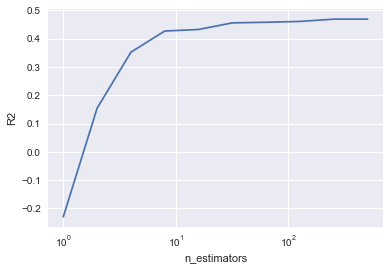

In [21]:
plt.plot((param_grid["n_estimators"]), [elem[1] for elem in gs.grid_scores_])
plt.xscale("log")
plt.xlabel("n_estimators")
plt.ylabel("R2")

Качество, как и ожидается, растет с увеличением числа базовых алгоритмов. Для валидации выберем 100 деревьев (быстро обучается и уже более-менее приналежит области стабильности качества), финальную модель будем обучать с 500 деревьями.

In [ ]:
# базовая логарифмическая шкала для max_features
param_grid = {"max_features":2**np.arange(1, 9)}

In [ ]:
# базовая шкала для остальных гиперпараметров
param_grid = {"max_depth":np.arange(1, 9, 2), "min_samples_leaf":[1, 3, 9, 27], "min_samples_split":[3, 9, 27, 81]}

__Задание 2.__

Теперь настроим градиентный бустинг, используя ту же выборку x1, y1.

1.  __(1.5 балла)__ Запустите кросс-валидацию для GradentBoostingRegressor по n_estimators и learning_rate. Постройте двумерный график или несколько одномерных (например, график качество-число деревьев при разных значениях длины шага). Выберите значения для использования при дальнейшей настройке и для финального обучения модели.
1.  __(1.25 балла)__ Постройте график зависимости качества от max_depth на кросс-валидации.
1.  __(1.25 балла)__ Выберите оптимальные значения для min_samples_split, min_samples_leaf, max_features с помощью кросс-валидации.
1.  __(0.5 балла)__ Обучите итоговую модель с выбранными значениями гиперпараметров на всей выборке x1, y1.

Примеры построения трехмерных графиков [здесь](https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html).

In [ ]:
# базовая шкала для числа деревьев и длины шага
param_grid = {"n_estimators":2**np.arange(10), "learning_rate":0.1**np.arange(5)}

In [ ]:
# базовая шкала для max_depth
param_grid = {"max_depth":np.arange(1, 9)}

In [ ]:
# базовая шкала для остальных гиперпараметров
param_grid = {"max_features":2**np.arange(1, 9, 2), "min_samples_leaf":[1, 3, 9, 27], 
              "min_samples_split":[3, 9, 27, 81]}

__Задание 3.__

 __(1 балл)__ Выведите качество случайного леса и градиентного бустинга на x2, y2, а также качество модели, представляющей собой усреднение предсказаний двух обученных моделей.

__Задание 4.__

 __(1 балл)__  Реализуйте блендинг. Обучите линейную регрессию на признаках - выходах двух моделей по выборке x2, y2. 

In [ ]:
from sklearn.linear_model import LinearRegression

__Задание 5.__

 __(0.5 балла)__ Выведите качество случайного леса и градиентного бустинга на x3, y3, качество модели, представляющей собой усреднение предсказаний двух обученных моделей, а также качество блендинга.